In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from basic_functions import data_load

Loading all the neccesary data

In [6]:
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")


Data loaded!
Data loaded!
Data loaded!
Data loaded!


# Decision Tree Model

In [7]:
from sklearn import tree
from sklearn.model_selection import train_test_split

clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train,y_train)
print(f"Depth: {clf_tree.get_depth()}")
print("Train:", clf_tree.score(X_train, y_train))
print("Test:", clf_tree.score(X_test, y_test))

Depth: 30
Train: 0.8985158057054742
Test: 0.7638857656847313


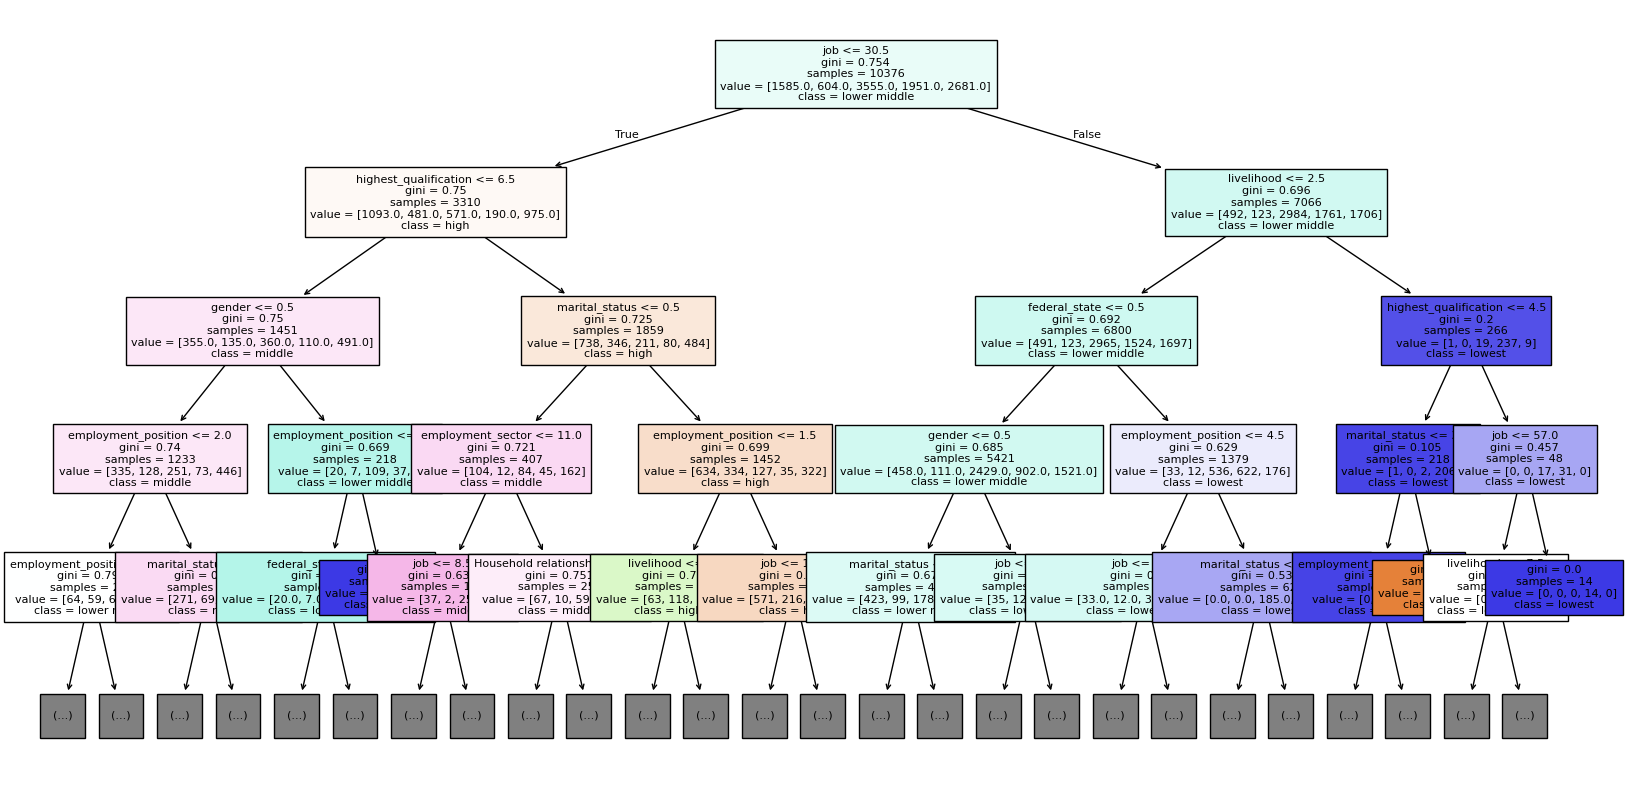

In [8]:
fig_size = plt.figure(figsize=(20,10))
tree.plot_tree(clf_tree,
               feature_names=X_train.columns,
               class_names=clf_tree.classes_,
               filled=True, 
               fontsize = 8, 
               max_depth=4)
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

dt_y_pred = clf_tree.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train, clf_tree.predict(X_train))
accuracy = accuracy_score(y_test, dt_y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, dt_y_pred)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Classification Report: Precision, Recall, F1-Score
print("Klassifikationsbericht:")
print(classification_report(y_test, dt_y_pred, zero_division=0))


Train Accuracy: 0.90
Accuracy: 0.76
Balanced Accuracy: 0.76
Klassifikationsbericht:
              precision    recall  f1-score   support

        high       0.73      0.71      0.72       650
     highest       0.72      0.76      0.74       240
lower middle       0.78      0.81      0.79      1530
      lowest       0.85      0.75      0.80       852
      middle       0.72      0.74      0.73      1175

    accuracy                           0.76      4447
   macro avg       0.76      0.76      0.76      4447
weighted avg       0.77      0.76      0.76      4447



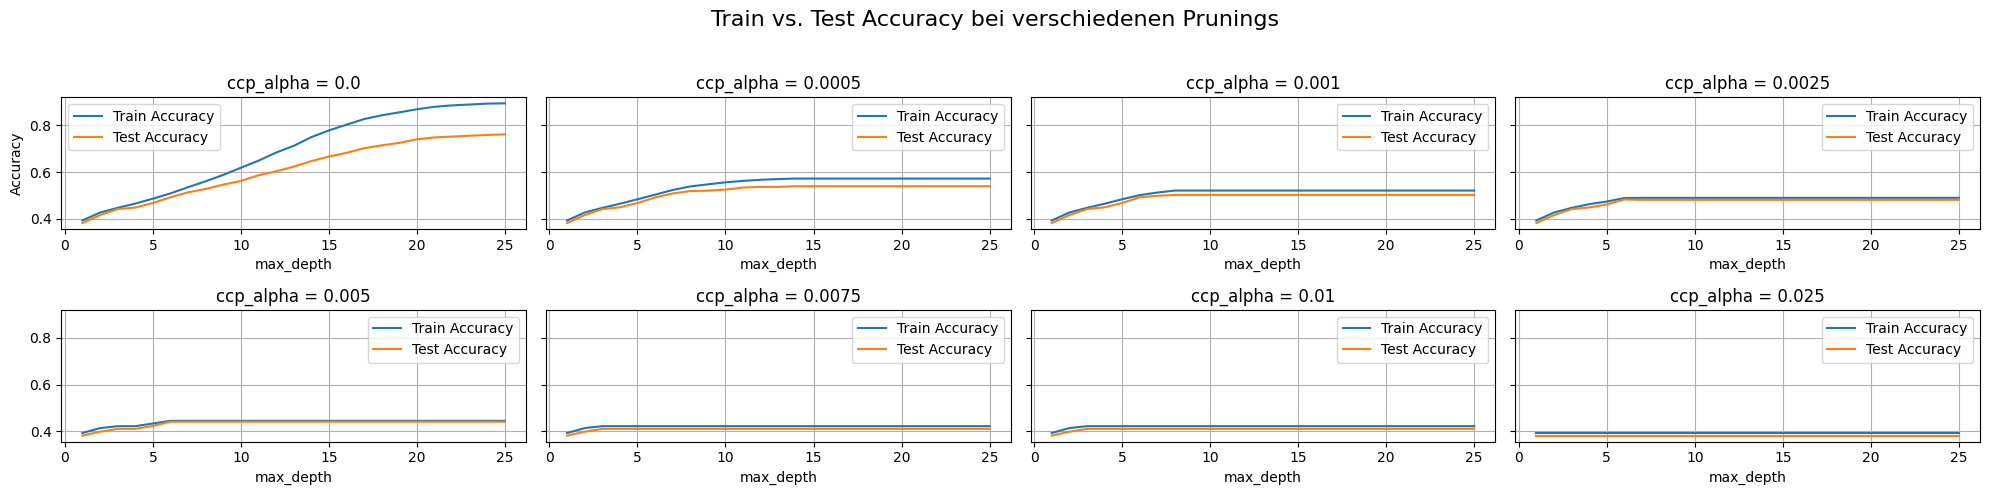

In [10]:
max_depths = range(1, 26)
ccp_alpha = [0.0, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025]

fig, axes = plt.subplots(2, 4, figsize=(20, 5), sharey=True)

for i, alpha in enumerate(ccp_alpha):
    train_scores = []
    test_scores = []

    for d in max_depths:
        clf = tree.DecisionTreeClassifier(max_depth=d, ccp_alpha=alpha, random_state=42)
        clf.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))

        train_scores.append(train_acc)
        test_scores.append(test_acc)
    row = i // 4
    col = i % 4
    ax = axes[row][col]
    ax.plot(max_depths, train_scores, label="Train Accuracy")
    ax.plot(max_depths, test_scores, label="Test Accuracy")
    ax.set_title(f"ccp_alpha = {alpha}")
    ax.set_xlabel("max_depth")
    if i == 0:
        ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()

plt.suptitle("Train vs. Test Accuracy bei verschiedenen Prunings", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Hyperparameter training (GRID-SEARCH)

In [11]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV


param_grid = {'max_features': ['sqrt', 'log2', None],
              'ccp_alpha': [0.0005, 0.001],
              'max_depth' : [5, 6, 7, 8, 9, 10],
              'criterion' :['gini', 'entropy']
             }

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train["income"])

,estimator,DecisionTreeClassifier()
,param_grid,"{'ccp_alpha': [0.0005, 0.001], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, ...], 'max_features': ['sqrt', 'log2', ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [12]:
grid_df = pd.DataFrame(grid.cv_results_)
filtered_grid_df = grid_df[["param_max_features", "param_ccp_alpha", "param_max_depth", "param_criterion", "mean_test_score"]]
filtered_grid_df.sort_values("mean_test_score", ascending=False).head()

,param_max_features,param_ccp_alpha,param_max_depth,param_criterion,mean_test_score
35,None,0.0005,10,entropy,0.542792
32,None,0.0005,9,entropy,0.532479
71,None,0.0010,10,entropy,0.531612
17,None,0.0005,10,gini,0.528527
68,None,0.0010,9,entropy,0.525444


In [13]:
print(grid.best_params_)
print(grid.best_score_)

{'ccp_alpha': 0.0005, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None}
0.5427922092996262


In [14]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

dt_y_pred_grid = grid.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train, grid.predict(X_train))
accuracy = accuracy_score(y_test, dt_y_pred_grid)
balanced_accuracy = balanced_accuracy_score(y_test, dt_y_pred_grid)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Classification Report: Precision, Recall, F1-Score
print("Klassifikationsbericht:")
print(classification_report(y_test, dt_y_pred_grid, zero_division=0))


Train Accuracy: 0.61
Accuracy: 0.56
Balanced Accuracy: 0.53
Klassifikationsbericht:
              precision    recall  f1-score   support

        high       0.50      0.49      0.50       650
     highest       0.47      0.46      0.47       240
lower middle       0.58      0.66      0.61      1530
      lowest       0.66      0.55      0.60       852
      middle       0.52      0.50      0.51      1175

    accuracy                           0.56      4447
   macro avg       0.55      0.53      0.54      4447
weighted avg       0.56      0.56      0.56      4447



# Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()


In [16]:
rf_clf.fit(X_train, y_train["income"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
rf_y_predict = rf_clf.predict(X_test)
# Accuracy
train_accuracy = accuracy_score(y_train, rf_clf.predict(X_train))
accuracy = accuracy_score(y_test, rf_y_predict)
balanced_accuracy = balanced_accuracy_score(y_test, rf_y_predict)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
# Classification Report: Precision, Recall, F1-Score
print("Klassifikationsbericht:")
print(classification_report(y_test, rf_y_predict, zero_division=0))

Train Accuracy: 0.90
Accuracy: 0.77
Balanced Accuracy: 0.77
Klassifikationsbericht:
              precision    recall  f1-score   support

        high       0.75      0.70      0.73       650
     highest       0.72      0.78      0.75       240
lower middle       0.78      0.80      0.79      1530
      lowest       0.84      0.79      0.81       852
      middle       0.73      0.76      0.75      1175

    accuracy                           0.77      4447
   macro avg       0.77      0.77      0.76      4447
weighted avg       0.77      0.77      0.77      4447

